Note: keystoneness figure (panel 5D) is output by the script `analysis/keystoneness.sh` on the healthy cohort.

# Before running this notebook

Ensure that the directory for fixed-cluster analysis output (`datasets/gibson/healthy/output/mdsine2/inference/merged_studies_fixed_cluster/mcmc.pkl`) exists and is discoverable.
Analysis files used in our paper can be found on Zenodo (https://doi.org/10.5281/zenodo.8208502).

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import mdsine2 as md2
from mdsine2.names import STRNAMES
import numpy as np
import os
import pandas as pd
import argparse
import matplotlib.colors as colors
import ete3

from Bio import Phylo
from pathlib import Path
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib import rcParams
from matplotlib import font_manager

[DEBUG] Using default logger (stdout, stderr).


In [2]:
rcParams['pdf.fonttype'] = 42

# font_dirs = ['figures/arial_fonts']
# font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

# for font_file in font_files:
#     ff = font_file.split("/")[-1]
#     if "._" not in ff:
#         font_manager.fontManager.addfont(font_file)
# # change font
# rcParams['font.family'] = 'Arial'

# helper functions

In [3]:
def phylogenetic_heatmap_gram_split(
    inoc_pkl, healthy_pkl, chain_healthy,
    tree_fname, taxa, healthy_filter
):
    '''Split the phylogenetic tree into gram negative and gram positive side by side.
    Gram positive is on left, gram negative is on right.
    Parameters
    ----------
    chain_healthy, chain_uc : str
        Paths to the mcmc.pkl objects for the healthy and uc cohort for a fixed
        clustering inference, respectively
    tree_fname : str
        Location to load the newick tree that shows the placement of the OTUs
    taxa : md2.TaxaSet
        This is the MDSINE2.TaxaSet object that contains all of the OTUs. This
        is used for naming
    '''
    # Load data and get taxa names
    # ---------------------------
    os.makedirs('tmp', exist_ok=True)
    names = set([])
    for chainname in [chain_healthy]:
        chain = md2.BaseMCMC.load(chainname)
        for otu in chain.graph.data.taxa:
            names.add(str(otu.name))
    names = list(names)

    # Split up into gram negative and gram positive
    # ---------------------------------------------
    gramneg_taxanames = []
    grampos_taxanames = []
    for name in names:
        taxon = taxa[name]
        if md2.is_gram_negative(taxon=taxon):
            gramneg_taxanames.append(name)
        else:
            grampos_taxanames.append(name)

    fig = plt.figure(figsize=(42,62))
    gs = fig.add_gridspec(128,112)

    # Make the number of rows of the heatmap proportional
    # ---------------------------------------------------
    pert_nrows = 7
    grampos_nrows = 111 - pert_nrows
    gramneg_nrows = int(grampos_nrows * len(gramneg_taxanames)/len(grampos_taxanames))
    ntwk_buffer = 0
    ntwk_row_start = 10 + gramneg_nrows + ntwk_buffer
    ntwk_nrows = int((111 - ntwk_row_start)/2)
    v_gap = 1

    # Make the number of columns of the heatmap proportional to healthy and uc
    tree_ncols = 24
    gap = 2
    gap_inoc = 4
    tree_branch_ncols = 7
    heatmap_width = 56 - tree_ncols
    pert_start = 3

    mcmc = md2.BaseMCMC.load(chain_healthy)
    healthy_nclusters = len(mcmc.graph[STRNAMES.CLUSTERING_OBJ])

    uc_ncols = 11# int(heatmap_width*uc_nclusters/(uc_nclusters + healthy_nclusters))
    healthy_ncols = 24 #heatmap_width - uc_ncols
    inoc_cols = 3

    max_healthy, min_healthy = get_scale(chain_healthy)
    max_= max_healthy
    min_= min_healthy
    if min_ < 1e-6:
        min_=1e-6
    if max_ > 1e-1:
        max_=1e-1

    # Make the subplots
    # -----------------
    # gram positive
    ax_grampos_tree = fig.add_subplot(gs[
        pert_nrows:pert_nrows+grampos_nrows + v_gap,
        2         :tree_branch_ncols])
    ax_grampos_tree_full = fig.add_subplot(gs[
        pert_nrows:pert_nrows+grampos_nrows + v_gap,
        2         :tree_branch_ncols], facecolor='none')
    ax_grampos_healthy_pert = fig.add_subplot(gs[
        pert_start         :pert_nrows,
        gap_inoc+tree_ncols+inoc_cols:gap_inoc+tree_ncols+inoc_cols
        +healthy_ncols])

    ax_grampos_pert = fig.add_subplot(gs[
        pert_start          :pert_nrows,
        gap_inoc+tree_ncols+inoc_cols:1+tree_ncols+healthy_ncols+
        +inoc_cols*2+gap+gap_inoc*2],
        facecolor='none')
    ax_grampos_healthy_abund = fig.add_subplot(gs[
        v_gap + pert_nrows:v_gap + pert_nrows+grampos_nrows,
        gap_inoc+tree_ncols+inoc_cols:tree_ncols+healthy_ncols+inoc_cols
        +gap_inoc])

    neg_start=57
    # gram negative
    ax_gramneg_tree = fig.add_subplot(gs[
        pert_nrows:pert_nrows+gramneg_nrows+v_gap,
        neg_start:neg_start+tree_branch_ncols])
    ax_gramneg_tree_full = fig.add_subplot(gs[
        pert_nrows :pert_nrows+grampos_nrows+v_gap,
        neg_start:neg_start+tree_branch_ncols], facecolor='none')
    ax_gramneg_healthy_pert = fig.add_subplot(gs[
        pert_start:pert_nrows, gap_inoc+neg_start+tree_ncols+inoc_cols:neg_start+tree_ncols+healthy_ncols+inoc_cols+ gap_inoc])
    ax_gramneg_pert = fig.add_subplot(gs[
        pert_start:pert_nrows, neg_start+tree_ncols+gap_inoc+inoc_cols:neg_start
        +tree_ncols+healthy_ncols+inoc_cols*2+gap+gap_inoc*2], facecolor='none')
    ax_gramneg_healthy_abund = fig.add_subplot(gs[
        v_gap+pert_nrows:pert_nrows+gramneg_nrows+v_gap,
        neg_start+tree_ncols+gap_inoc+inoc_cols:neg_start+tree_ncols+healthy_ncols+
        gap_inoc+inoc_cols])

    bayes_rows = 20
    bayes_row_gap = 20


    # Plot gram positive subplots
    # ---------------------------
    ax_grampos_tree, grampos_taxaname_order = _make_phylogenetic_tree(
        tree_fname=tree_fname, names=grampos_taxanames, taxa=taxa, fig=fig,
        ax=ax_grampos_tree, figlabel='A', figlabelax=ax_grampos_tree_full)

    ax_grampos_healthy_abund, grampos_healthy_colorder, grampos_module_df = _make_cluster_membership_heatmap(
        chainname=chain_healthy, study_pkl=healthy_pkl, ax=ax_grampos_healthy_abund,
        order=grampos_taxaname_order, vmax=max_, vmin=min_,
        filter_taxa=healthy_filter, binary=False, fig=fig, make_colorbar=False, count=1)

    ax_grampos_healthy_pert = _make_perturbation_heatmap(chainname=chain_healthy,
        min_bayes_factor=10, ax=ax_grampos_healthy_pert, colorder=grampos_healthy_colorder,
        fig=fig, make_colorbar=False, figlabel='', title=None, render_labels=True)

    ax_grampos_tree = _remove_border(ax_grampos_tree)
    ax_grampos_pert = _remove_border(ax_grampos_pert)
    ax_grampos_pert.set_title('   Gram + Bacteria', fontsize=80, pad=80, loc="left")

    # Plot gram negative subplots
    # ---------------------------
    ax_gramneg_tree, gramneg_taxaname_order = _make_phylogenetic_tree(
        tree_fname=tree_fname, names=gramneg_taxanames, taxa=taxa, fig=fig,
        ax=ax_gramneg_tree, figlabel='B', figlabelax=ax_gramneg_tree_full)

    ax_gramneg_healthy_abund, gramneg_healthy_colorder, gramneg_module_df = _make_cluster_membership_heatmap(
        chainname=chain_healthy, study_pkl=healthy_pkl, ax=ax_gramneg_healthy_abund,
        order=gramneg_taxaname_order, vmax=max_, vmin=min_, filter_taxa=healthy_filter,
        binary=False, fig=fig, make_colorbar=True, count=3)

    ax_gramneg_healthy_pert = _make_perturbation_heatmap(chainname=chain_healthy,
        min_bayes_factor=10, ax=ax_gramneg_healthy_pert, colorder=gramneg_healthy_colorder,
        fig=fig, make_colorbar=True, figlabel='', title=None, render_labels=True)

    ax_gramneg_tree = _remove_border(ax_gramneg_tree)
    ax_gramneg_pert = _remove_border(ax_gramneg_pert)
    ax_gramneg_tree_full = _remove_border(ax_gramneg_tree_full)
    ax_grampos_tree_full = _remove_border(ax_grampos_tree_full)

    ax_gramneg_pert.set_title('   Gram - Bacteria', fontsize=80, pad=80,
       loc="left")

    suffix_taxon = {'genus': '*',
        'family': '**', 'order': '***', 'class': '****', 'phylum': '*****',
        'kingdom': '******'}
    text = 'Taxonomy\n      Key\n'
    text_ = ""
    for taxon in suffix_taxon:
        text_ += ' {} : {}\n'.format(suffix_taxon[taxon], taxon)
    text_ = text_[0:-1]
    fig.text(x=0.35, y=0.076, s=text, fontsize=50, fontweight="bold")
    fig.text(x=0.37, y=0.020, s=text_, fontsize=40)
    fig.subplots_adjust(wspace=0.00, left=0.005, right=0.995, hspace=0.1,
        top=.96, bottom=0.02)

    return grampos_module_df, gramneg_module_df

def _remove_border(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.set_xlabel('')
    ax.set_ylabel('')
    return ax

def _make_phylogenetic_tree(tree_fname, names, taxa, ax, fig, figlabel=None,
    figlabelax=None):

    tree = ete3.Tree(tree_fname)
    tree.prune(names, True)
    tree.write(outfile='tmp/temp.nhx')
    fontsize = 31

    taxonomies = ['family', 'order', 'class', 'phylum', 'kingdom']
    suffix_taxa = {'genus': '*', 'family': '**', 'order': '***', 'class': '****'
        , 'phylum': '*****', 'kingdom': '******'}
    extra_taxa_added = set([])

    tree = Phylo.read('tmp/temp.nhx', format='newick')
    Phylo.draw(tree, axes=ax, do_show=False, show_confidence=False)
    # Get current limits, add offset
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin - 0.5, ymax - 0.5)  # Positive value shifts tree up
        
    taxa_order = []
    for text in ax.texts:
        taxa_order.append(text._text)
        # Substitute the name of the taxon with the species/genus if possible
        taxonname = str(text._text).replace(' ','')
        taxon = taxa[taxonname]
        suffix = '' # for defining taxonomic level outside genus
        if taxon.tax_is_defined('genus'):
            taxonname = ' ' + taxon.taxonomy['genus']
            if taxon.tax_is_defined('species'):
                spec = taxon.taxonomy['species']
                l = spec.split('/')
                if len(l) < 5:
                    spec = '/'.join(l)
                    taxonname = taxonname + ' {}'.format(spec)
                elif len(l) >= 5:
                    spec = '/'.join(l[:2])
                    taxonname = taxonname + ' {}'.format(spec)
            else:
                suffix = suffix_taxa['genus']
        else:
            found = False
            for taxlevel in taxonomies:
                if found:
                    break
                if taxon.tax_is_defined(taxlevel):
                    found = True
                    taxonname = ' ' + taxon.taxonomy[taxlevel]
                    suffix = suffix_taxa[taxlevel]
                    extra_taxa_added.add(taxlevel)

            if not found:
                taxonname = '#'*40

        taxonname += ' ' + taxon.name
        taxonname = ' ' + suffix + taxonname
        text._text = taxonname
        text._text = text._text + '- ' * (65 - len(text._text))
        text.set_fontsize(fontsize)

    if figlabel is not None:
        figlabelax.text(x=0.15, y=1.0, s=figlabel, fontsize=60, fontweight='bold',
            transform=ax.transAxes)
    #ax.set_aspect("equal")
    return ax, taxa_order

def _make_perturbation_heatmap(chainname, min_bayes_factor, ax, colorder, fig,
    make_colorbar=True, figlabel=None, title=None, render_labels=True):

    chain = md2.BaseMCMC.load(chainname)
    subjset = chain.graph.data.subjects
    clustering = chain.graph[STRNAMES.CLUSTERING_OBJ]

    matrix = np.zeros(shape=(len(chain.graph.perturbations), len(clustering)))
    bf_matrix = np.zeros(shape=(len(chain.graph.perturbations), len(clustering)))

    index = []
    for pidx, perturbation in enumerate(chain.graph.perturbations):
        index.append(perturbation.name)

        bayes_factor = md2.generate_perturbation_bayes_factors_posthoc(mcmc=chain,
            perturbation=perturbation, section='posterior')
        bf_condensed = md2.condense_fixed_clustering_perturbation(bayes_factor,
            clustering=clustering)
        values = md2.summary(perturbation, section='posterior', only=["mean"])['mean']

        for cidx in range(len(clustering)):
            aidx = list(clustering.clusters[clustering.order[cidx]].members)[0]
            if bayes_factor[aidx] >= min_bayes_factor:
                matrix[pidx, cidx] = values[aidx]
        bf_matrix[pidx] = bf_condensed


    df = pd.DataFrame(matrix, columns=_make_names_of_clusters(len(clustering)),
        index=index)
    bf_df = pd.DataFrame(bf_matrix, columns=_make_names_of_clusters(len(clustering)),
        index=index)

    #df = df[colorder]
    #bayes = pd.read_csv('healthy_bayes_factors.csv', index_col=0)
    bf_df = bf_df.mask(bf_df < np.sqrt(10), np.NaN)
    bf_df = bf_df.mask((bf_df>=np.sqrt(10)) & (bf_df<10), .01)
    bf_df = bf_df.mask((bf_df>=10) & (bf_df<100), .1)
    bf_df = bf_df.mask((bf_df>=100), 1)

    np_df = df.to_numpy()
    np_df = np.where(np_df<-5, -5, np_df)
    np_df = np.where(np_df>5, 5, np_df)

    N = np_df.shape[1]

    x=np.append(np.append(np.arange(1, N+1), np.arange(1,N+1)), np.arange(1,N+1))
    y=np.append(np.append(np.repeat('High Fat Diet',N),
        np.repeat('Vancomycin',N)), np.repeat('Gentamicin',N))

    bvec=np.append(np.append(bf_df.iloc[0,:], bf_df.iloc[1,:]), bf_df.iloc[2,:])

    if make_colorbar:
        cax_strength = fig.add_axes([0.17, 0.01, 0.012, 0.065]) #[0.56, 0.31, 0.015, 0.1]
        cax_bf = fig.add_axes([0.26, -0.001, 0.015, 0.12])

        heatmap(x=pd.Series(x), y=pd.Series(y), ax = ax, cax=cax_strength,
        render_labels=render_labels, size_scale = 500, size=bvec,
        size_range=[0, 1], y_order=['Gentamicin', 'Vancomycin', 'High Fat Diet'],
        color=np.ravel(np_df), color_range=[-5, 5],
        palette=sns.color_palette("RdBu", n_colors=200), marker='o')

        txt=['$\sqrt{10} < K_\mathrm{BF}  \leq 10$',
            '$ 10 < K_\mathrm{BF}\leq 100$', '$K_\mathrm{BF}>100$' ]
        heatmap(x=[1, 1, 1], y=txt, ax=cax_bf, cax=None, fsize=30,
        size_scale = 600, size_range=[0,1], size=[.01, .1, 1],
        y_order=txt, marker='o',
        render_labels=True, title=" Bayes \nFactor\n", tick_right=True)

    else:
        heatmap(x=pd.Series(x), y=pd.Series(y), ax=ax, cax=None,
        render_labels=render_labels, size_scale = 500, size=bvec,
        size_range=[0, 1], y_order=['Gentamicin', 'Vancomycin', 'High Fat Diet'],
        color=np.ravel(np_df), color_range=[-5, 5],
        palette=sns.color_palette("RdBu", n_colors=200), marker='o')

    if figlabel is not None:
        ax.set_title(figlabel, fontsize=60, loc="left", fontweight="bold")

    if title is not None:
        ax.set_title(title, fontsize=40)

    return ax

def heatmap(x, y, ax, cax=None, render_labels=False, title=None, tick_right=False,
    fsize=35, **kwargs):

    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 100 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("magma_r", n_colors)

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale

    if 'x_order' in kwargs:
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs:
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}


    marker = kwargs.get('marker', 'o')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order', 'xlabel', 'ylabel'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size],
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    #ax.set_xticklabels([k for k in x_to_num], horizontalalignment='right')
    if render_labels:
        ax.set_yticks([v for k,v in y_to_num.items()])
        ax.set_yticklabels([k for k in y_to_num], fontsize=fsize)
        ax.tick_params(axis='both', which='major', pad=15)
    else:
        ax.set_yticks([v for k,v in y_to_num.items()])
        ax.set_yticklabels([])
    ax.grid(False, 'major')
    ax.grid(b=True, which='minor', color='black', linestyle='-')

    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('none')

    ax.set_xticklabels([])
    ax.tick_params(axis="both", length=0, width=0)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
        ax.spines[axis].set_color('black')

    ax.set_xlabel(kwargs.get('xlabel', ''))
    ax.set_ylabel(kwargs.get('ylabel', ''))
    if title is not None:
        ax.set_title(title, fontsize=50, fontweight="bold")
    if tick_right:
        ax.yaxis.tick_right()

    ax.set_aspect("equal")

    # Add color legend on the right side of the plot
    #if color_min < color_max:
    if cax is not None and color_min<color_max:
        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bar
        bar_height = bar_y[1] - bar_y[0]
        cax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0.5)
        cax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        cax.set_ylim(-5, 5)
        cax.grid(False) # Hide grid
        cax.set_facecolor('none') # Make background white
        cax.set_xticks([]) # Remove horizontal ticks
        cax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        cax.yaxis.tick_right() # Show vertical ticks on the right
        cax.set_title('Perturbation\n  Effect\n', fontsize=50, fontweight='bold')
        cax.tick_params(axis='y', labelsize=35)

def get_scale(name):

    chain = md2.BaseMCMC.load(name)
    subjset = chain.graph.data.subjects
    rel_abund = np.zeros(len(subjset.taxa))
    for subj in subjset:
        M = subj.matrix()['rel']
        start_idx = np.searchsorted(subj.times, 14)
        end_idx = np.searchsorted(subj.times, 21.5)

        rel_abund += np.mean(M[:,start_idx:end_idx], axis=1)
    rel_abund /= len(subjset)
    temp = np.where(rel_abund==0, np.inf, rel_abund)
    max_rel = np.max(rel_abund)
    min_rel = np.min(temp)

    return max_rel, min_rel

def is_zero_abundance(order, studyset, dict_):
    zero_abundant = {}
    for subj in studyset:
        M = subj.matrix()['rel']
        #print(M.shape)
        for otu in order:
            idx = dict_[otu.strip()]
            if np.sum(M[idx, :]) == 0:
                if otu.strip() not in zero_abundant:
                    zero_abundant[otu.strip()] = 0
                zero_abundant[otu.strip()] += 1
    final_dict = {}
    for otu in zero_abundant:
        if zero_abundant[otu] == len(studyset):
            final_dict[otu] = zero_abundant[otu]

    return final_dict


def _make_cluster_membership_heatmap(chainname, study_pkl, ax, order, binary, fig,
    vmax, vmin, filter_taxa, make_colorbar=True, figlabel=None, count=0):
    '''Make the heatmap of the cluster membership
    If `binary` is True, then we just have a binary vector of the membership of
    the taxon in the cluster. If `binary` is False, then the coloring is the average relative
    abundance of the ASV and the colorbar is on a log scale.
    '''
    chain = md2.BaseMCMC.load(chainname)
    taxas = [otu.name for otu in chain.graph.data.taxa]
    subjset = chain.graph.data.subjects
    clusters = chain.graph[STRNAMES.CLUSTERING_OBJ].tolistoflists()
    all_taxa = study_pkl.taxa
    taxa_idx_dict = {all_taxa[i].name : i for i in range(len(all_taxa))}
    zero_abundant_count = is_zero_abundance(order, study_pkl, taxa_idx_dict)

    # If binary is False, then get the relative abundances of the ASVS
    rel_abund = None
    if not binary:
        rel_abund = np.zeros(len(subjset.taxa))
        for subj in subjset:
            M = subj.matrix()['rel']
            start_idx = np.searchsorted(subj.times, 14)
            end_idx = np.searchsorted(subj.times, 21.5)

            rel_abund += np.mean(M[:,start_idx:end_idx], axis=1)
        rel_abund /= len(subjset)
    max_rel = np.max(rel_abund)
    min_rel = np.min(rel_abund)

    if min_rel < 1e-6:
        min_rel = 1e-6
    rel_abund = np.where(rel_abund>=vmax, vmax, rel_abund)
    rel_abund[rel_abund == 0] = vmax+1e-1

    matrix = np.zeros(shape=(len(subjset.taxa), len(clusters)))
    for cidx, cluster in enumerate(clusters):
        for oidx in cluster:
            if binary:
                matrix[oidx, cidx] = 1
            else:
                matrix[oidx, cidx] = rel_abund[oidx]

    index = [taxon.name for taxon in subjset.taxa]

    iii = 0
    for taxonnew in order:
        if taxonnew not in index:
            index.append(taxonnew)
            iii += 1

    # Add in nan rows in places that order is not in index
    matrix = np.vstack((matrix, np.zeros(shape=(iii, matrix.shape[1]))*np.nan))
    order = [str(a).replace(' ', '') for a in order]

    df = pd.DataFrame(matrix,
        columns=_make_names_of_clusters(len(clusters)),
        index=index)

    df = df.reindex(order)

    cols = np.arange(len(df.columns))
    #df.to_csv(str(count)+".csv", sep=",")
    colnames = df.columns
    newcolnames = []
    for idx in cols:
        newcolnames.append(colnames[idx])
    df = df[newcolnames]

    if not binary:
        kwargs = {'norm': LogNorm(vmin=vmin, vmax=vmax+1e-4)}
    else:
        kwargs = {}

    cmap = sns.cubehelix_palette(n_colors=100, as_cmap=True, start=2, rot=0,
        dark=0.3, light=0.9)
    cmap.set_bad(color='gray')
    cmap.set_under(color='white')
    cmap.set_over(color="yellowgreen")

    cmap_masked = colors.ListedColormap(['silver', "green"])
    vals = df.values
    vals += min_rel - 1e-10
    new_vals = []
        
    for x in range(vals.shape[0]):
        otu = order[x].strip()

        if otu in zero_abundant_count:
            for y in range(vals.shape[1]):

                ax.plot(y, x, marker="o", color="black", markersize=5)
            new_vals.append([1] * vals.shape[1])

        else:
            if otu not in filter_taxa and otu not in taxas:
                #for y in range(vals.shape[1]):
                #    ax.plot(y, x, marker="^", markersize=10, color="black")
                new_vals.append([1] * vals.shape[1])
            else:
                new_vals.append([np.nan] * vals.shape[1])
    new_vals = np.asarray(new_vals)
    masked_array = np.ma.masked_where(np.isnan(new_vals), new_vals)

    im = ax.imshow(vals, cmap=cmap, aspect='auto', **kwargs)
    im_masked = ax.imshow(masked_array, cmap=cmap_masked, aspect="auto")
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    label_s = "M"
    xticklabels = [label_s + str(i) for i in np.arange(1, len(df.columns)+1,
        step=1, dtype=int)]
    ax.set_xticks(ticks=np.arange(len(df.columns), step=1))
    ax.set_xticklabels(labels=xticklabels)
    for i, tick in enumerate(ax.xaxis.get_major_ticks()):
        tick.label.set_rotation(90)
        tick.label.set_fontsize(30)
        # tick.label.set_horizontalalignment('right')

    # Make grid
    ax.set_xticks(np.arange(0.5, len(df.columns), 1), minor=True)
    ax.set_yticks(np.arange(0.5, len(df.index), 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.1)

    ax.tick_params(axis='both', which='minor', left=False, bottom=False,
        labelsize=34)
    ax.set_xlabel("Module", fontsize=50, fontweight="bold")

    if make_colorbar:
        cbaxes = fig.add_axes([0.05, 0.01, 0.012, 0.065]) # left, bottom, width, height
        cbar = plt.colorbar(im, cax=cbaxes, orientation='vertical')
        cbar.ax.set_title(' Relative\nAbundance\n', fontsize=50, fontweight='bold')
        cbar.ax.tick_params(labelsize=35, length=10, which="major")
        cbar.ax.tick_params(length=0, which="minor")

        legend_elements = [Line2D([0], [0], marker= "s", color="white",
        label= "Colonized consistently but not\ndetected in Days 14 - 21",
            markerfacecolor="yellowgreen",
            markersize=35)]

        lgd_ax = fig.add_axes([0.65, 0.1, 0.05, 0.05])
        lgd_ax.legend(handles=legend_elements, loc="center", fontsize=35,
            frameon=False, labelspacing=1)
        lgd_ax = _remove_border(lgd_ax)

    df[df < 1e-6] = np.nan
    return ax, newcolnames, df

def _make_names_of_clusters(n_clusters):
    '''Standardize the way to name the clusters so that they are all the same between
    eachother
    '''
    return ['Cluster {}'.format(i) for i in range(n_clusters)]

# render

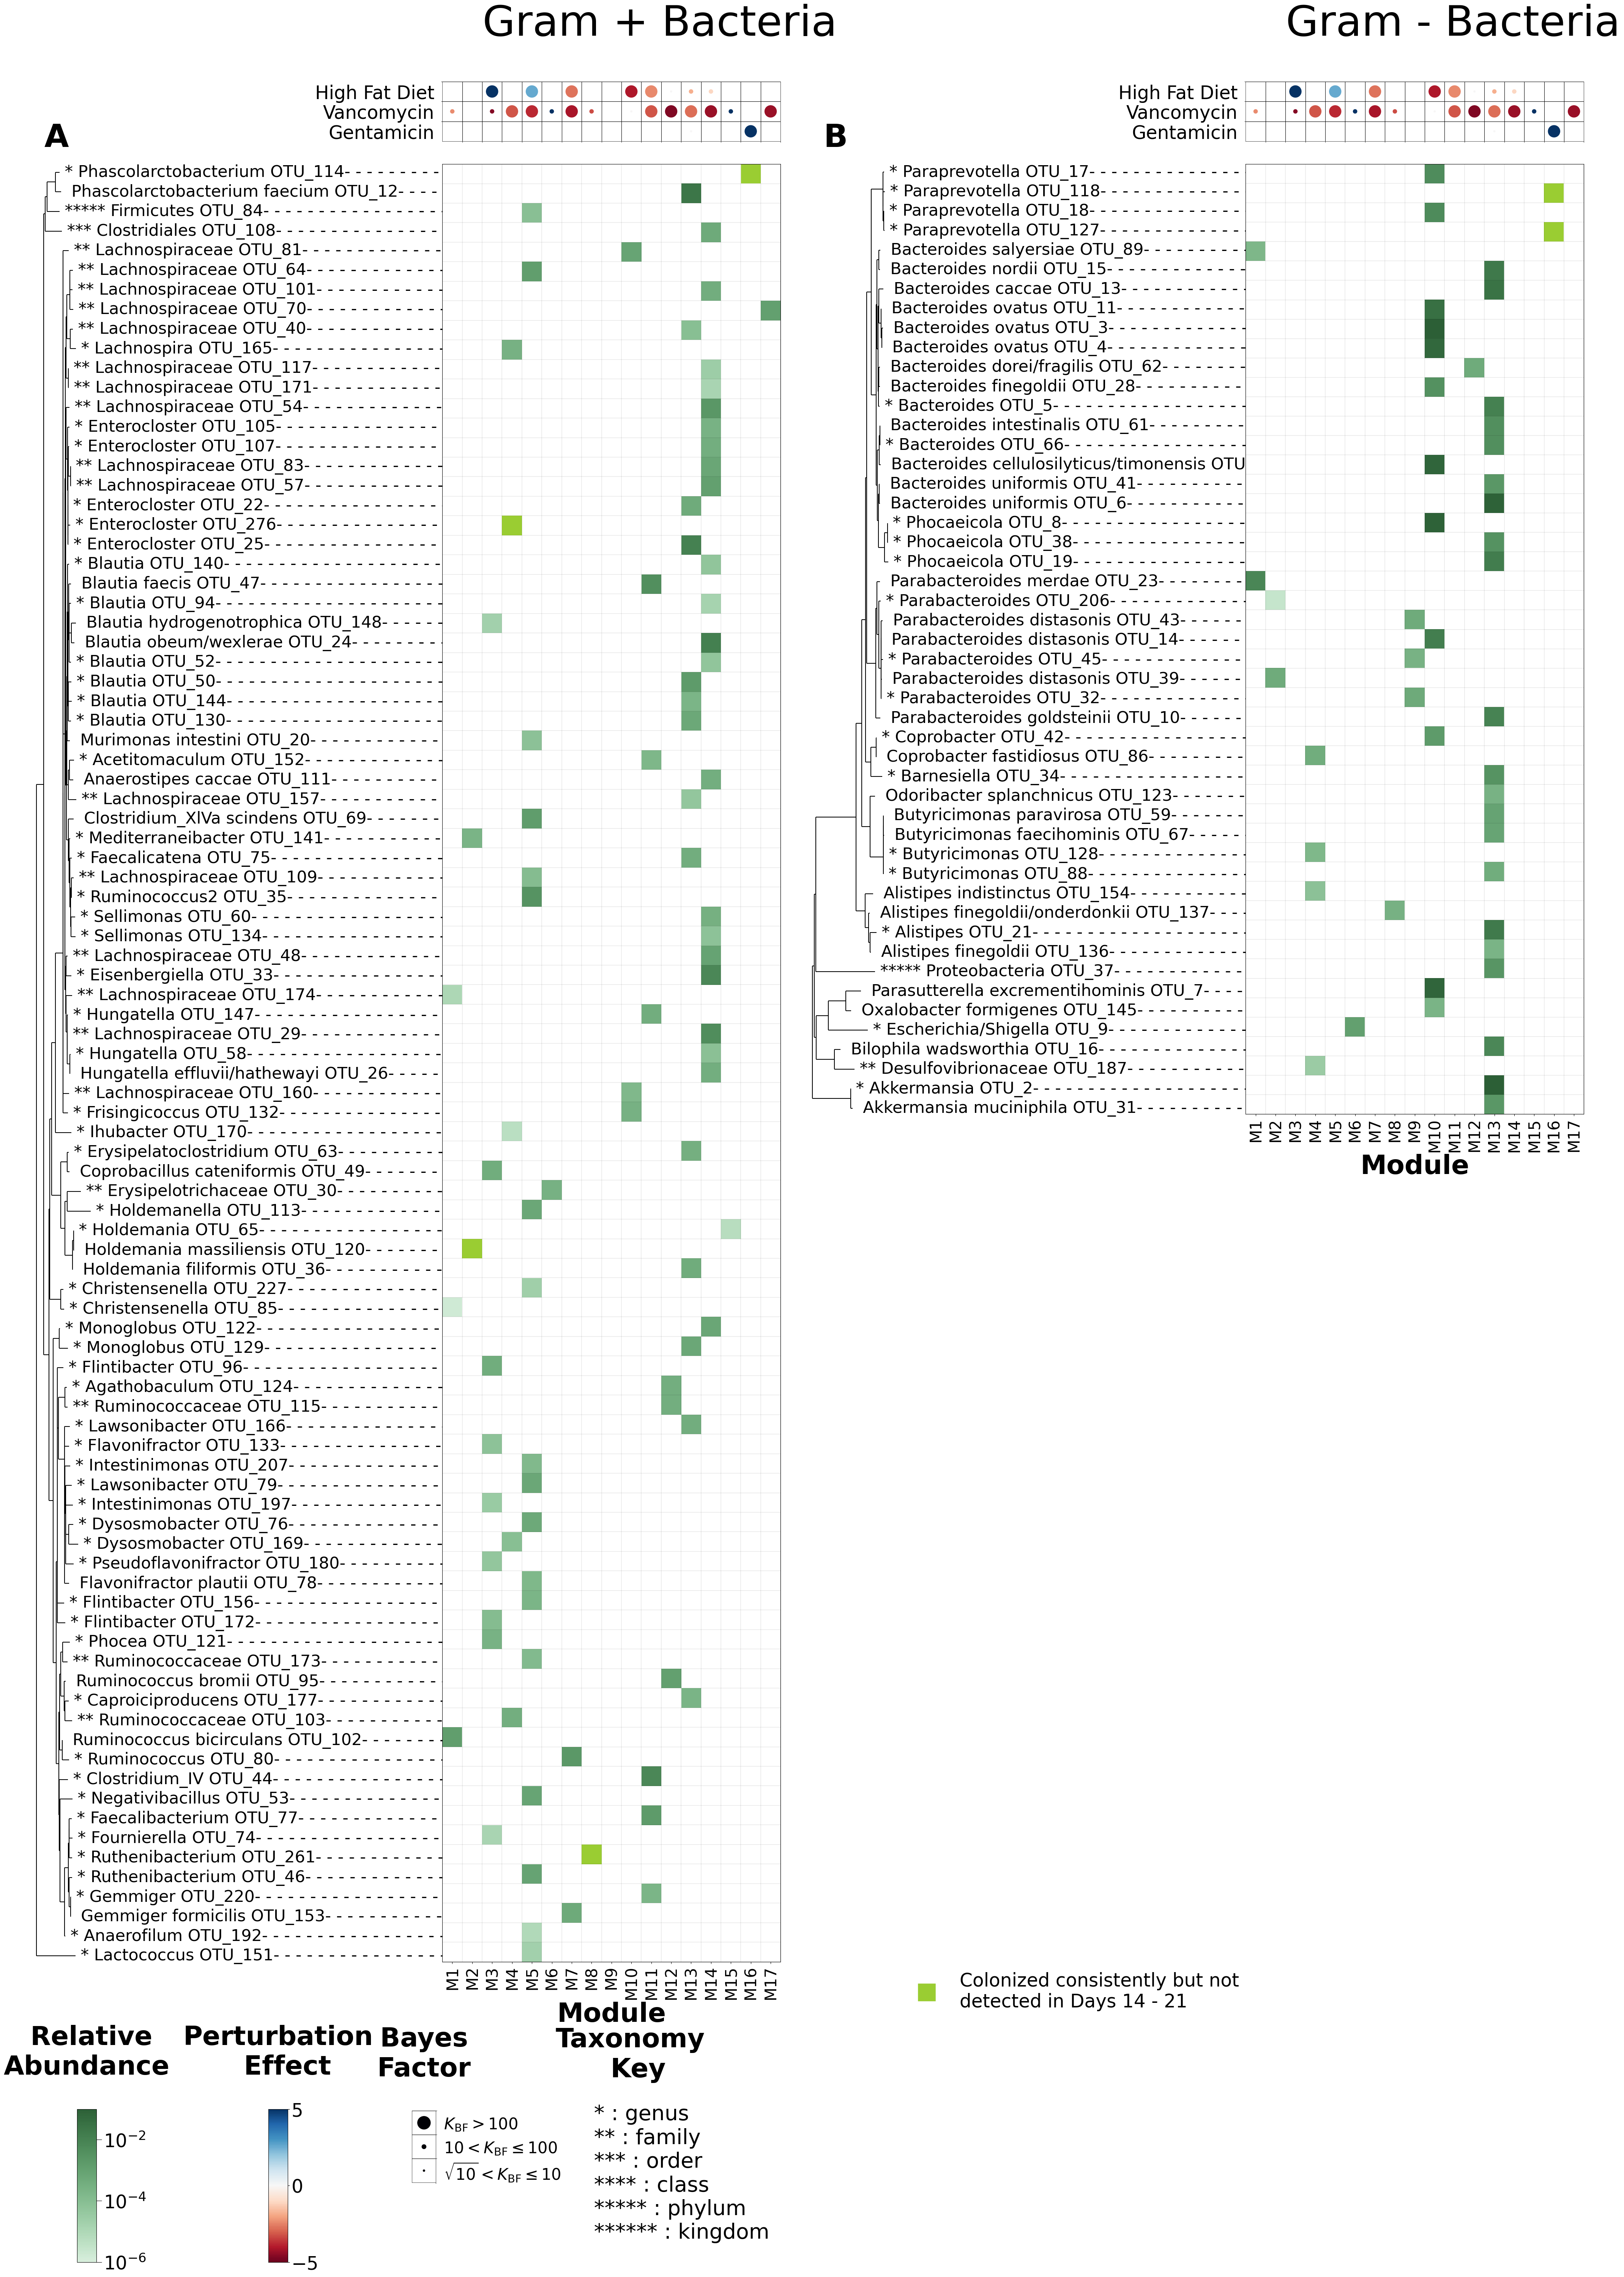

In [4]:
""" mdsine2 preprocessed input directory (output of preprocess workflow) """
preprocessed_input_dir = Path().resolve().parent / "datasets" / "gibson" / "healthy" / "preprocessed"
fixed_cluster_mcmc_path = Path().resolve().parent / "datasets" / "gibson" / "healthy" / "output" / "mdsine2" / "inference" / "merged_studies_fixed_cluster" / "mcmc.pkl"
tree_file_path = Path().resolve().parent / "datasets" / "gibson" / "healthy" / "metadata_OTU" / "newick_tree_query_reads.nhx"

""" mdsine2 input files """
study_inoc = md2.Study.load(preprocessed_input_dir / "gibson_inoculum_agg.pkl")
study_healthy = md2.Study.load(preprocessed_input_dir / "gibson_healthy_agg.pkl")
healthy_filtered_study = md2.Study.load(preprocessed_input_dir / "gibson_healthy_agg_filtered.pkl")
full_taxa = study_inoc.taxa

""" render figure """
grampos_values, gramneg_values = phylogenetic_heatmap_gram_split(
    inoc_pkl=study_inoc, 
    healthy_pkl=study_healthy,
    chain_healthy=fixed_cluster_mcmc_path, 
    tree_fname=str(tree_file_path),
    taxa=full_taxa,
    healthy_filter=[otu.name for otu in healthy_filtered_study.taxa]
)

# study_healthy = md2.Study.load(Path().resolve().parent / "datasets" / "gibson/healthy/preprocessed/gibson_healthy_agg_filtered.pkl")
# taxa = study_healthy.taxa
# print([otu.name for otu in study_healthy.taxa])
# phylogenetic_heatmap_gram_split(
#     healthy_pkl=study_healthy, 
#     chain_healthy=str(fixed_cluster_mcmc_path),
#     tree_fname=str(tree_file_path), 
#     taxa=taxa, 
#     healthy_filter=[otu.name for otu in study_healthy.taxa]
# )

In [5]:
table_dir = Path("tables/fig5_modules")
table_dir.mkdir(exist_ok=True, parents=True)

grampos_values.to_csv(table_dir / "gram_pos.tsv", sep='\t', index=True)
gramneg_values.to_csv(table_dir / "gram_neg.tsv", sep='\t', index=True)